In [1]:
!git clone https://github.com/SHIVITG/Signature_Detection_Analysis.git

Cloning into 'Signature_Detection_Analysis'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 520 (delta 27), reused 37 (delta 14), pack-reused 465
Receiving objects: 100% (520/520), 266.13 MiB | 29.03 MiB/s, done.
Resolving deltas: 100% (258/258), done.
Checking out files: 100% (518/518), done.


In [2]:
cd Signature_Detection_Analysis/

/content/Signature_Detection_Analysis


In [3]:
ls

input_data/       README.md         Signature_Forgery_Detection.ipynb
model.py          requirements.txt  tensorflow_details.py
preprocessing.py  Results/          Weights/
__pycache__/      run.py


In [4]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras import models
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
import keras.backend.tensorflow_backend as tfback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# tf.debugging.set_log_device_placement(True)

Using TensorFlow backend.


In [0]:
from preprocessing import fetch_groups
from tensorflow_details import _get_available_gpus
from model import create_base_network_signet, eucl_dist_output_shape, contrastive_loss, euclidean_distance, load_and_check_model, test_model, predict_score, generate_batch,compute_accuracy_roc

In [6]:
# ----------------------------------------------------------------------------------------------------#
# ----------------------------------------STEP :1-----------------------------------------------------#
#--------------------------------Splitting into train & test------------------------------------------#

orig_groups, forg_groups = fetch_groups()
orig_train, orig_test, forg_train, forg_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=1)
orig_train, orig_val, forg_train, forg_val = train_test_split(orig_train, forg_train, test_size=0.25, random_state=1)
print("Report: Created train, validation and test data sucessfully. ")

Report: Dictionary of forged and original images creating

Images from input_data/BHSig260/Hindi/ appended sucessfully:
Images from input_data/BHSig260/Bengali/ appended sucessfully:

Report: Dictionary of forged and original images created

Details of orig_groups and forg_groups:-
The length of orig_groups: 4
The length of forg_groups: 4
Report: Created train, validation and test data sucessfully. 


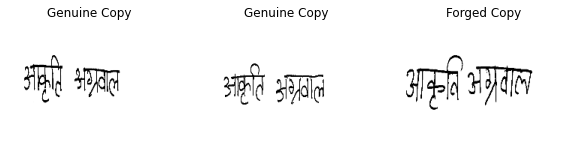

In [7]:
# ----------------------------------------------------------------------------------------------------#
# ----------------------------------------STEP :2-----------------------------------------------------#
#----------------------------Visualize images to see the signatures-----------------------------------#

img_h, img_w = 155, 220

def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

visualize_sample_signature()

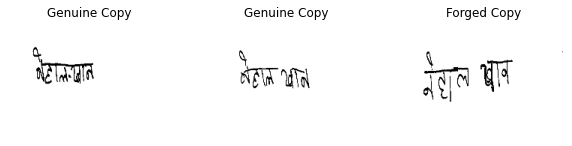

In [8]:
visualize_sample_signature()

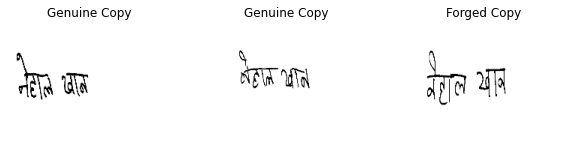

In [9]:
visualize_sample_signature()

In [0]:
# ----------------------------------------------------------------------------------------------------#
# -------------------------------------------STEP :3--------------------------------------------------#
#-------------------------------------------Run model-------------------------------------------------#

tfback._get_available_gpus = _get_available_gpus
input_shape=(img_h, img_w, 1)

# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
p_model = Model(input=[input_a, input_b], output=distance, name = 'head_model')

num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
p_model.compile(loss=contrastive_loss, optimizer=rms)
p_model.summary()


callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('Weights/model-signet-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

batch_sz = 128
results = p_model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 20,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

In [0]:
def load_and_check_model(weight):
    """
    Print validation Accuracy for all saved weights and choose the best for test set
    (TODO - Perform Ensemble of Weights)
    """
    p_model.load_weights(weight)

    val_gen = generate_batch(orig_val, forg_val, 1)
    pred, tr_y = [], []
    for i in range(num_val_samples):
        (img1, img2), label = next(val_gen)
        tr_y.append(label)
        pred.append(p_model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
    return tr_acc, threshold


def test_model(weight):
    model.load_weights(weight)

    test_gen = generate_batch(orig_test, forg_test, 1)
    pred, tr_y = [], []
    for i in range(num_test_samples):
        (img1, img2), label = next(test_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y), plot_far_frr = True)
    return tr_acc, threshold

# Using Xavier Initialisation on Uniform distribution
# Thus if the difference score is less than threshold we predict the test image as Genuine and if the difference score is greater than threshold we predict it to be as forged

def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = generate_batch(orig_test, forg_test, 1)
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = p_model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

In [0]:
# ----------------------------------------------------------------------------------------------------#
# -------------------------------------------STEP :4--------------------------------------------------#
#------------------------------------Predict Accuracy-------------------------------------------------#

acc_thresh = []
for i in range(1,10,1):
    acc_thresh.append(load_and_check_model('Weights/model-signet-'+str(i).zfill(3)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')

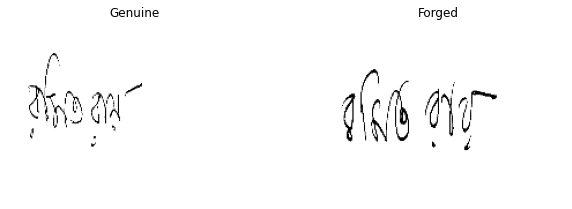

Difference Score =  0.27155632
Its a Genuine Signature


In [46]:
predict_score()

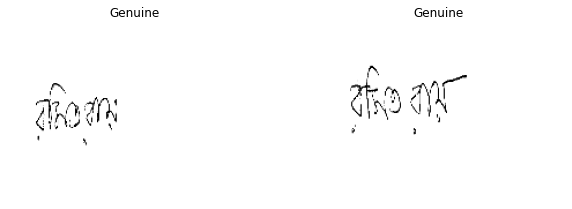

Difference Score =  0.20794466
Its a Genuine Signature


In [47]:
predict_score()

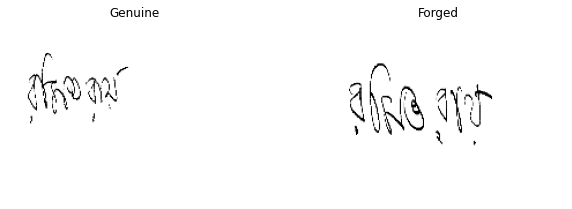

Difference Score =  0.73709553
Its a Forged Signature


In [48]:
predict_score()

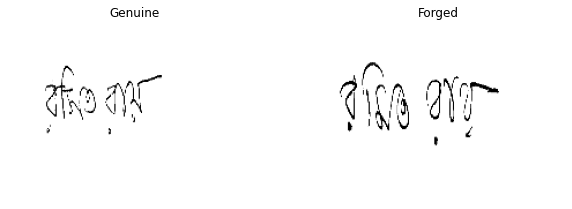

Difference Score =  0.71994656
Its a Forged Signature


In [49]:
predict_score()

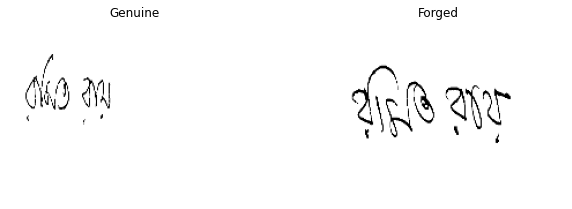

Difference Score =  0.93573505
Its a Forged Signature


In [50]:
predict_score()

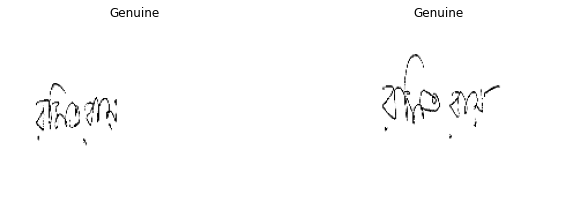

Difference Score =  0.36470827
Its a Genuine Signature


In [51]:
predict_score()